In [ ]:
%load_ext autoreload

In [180]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import gensim
from gensim.models.phrases import Phrases, Phraser
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from cord19.utils.utils import flatten_lists, clean_and_tokenize, two_proportions_test

# Remove this if you use data_getters and just import get_engine
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from configparser import ConfigParser
def get_engine(config_path, database="production", **engine_kwargs):
    '''Get a SQL alchemy engine from config'''
    cp = ConfigParser()
    cp.read(config_path)
    cp = cp["client"]
    url = URL(drivername="mysql+pymysql", database=database,
              username=cp["user"], host=cp["host"], password=cp["password"])
    return create_engine(url, **engine_kwargs)


# Remove this if you use the data_getters and just import get_arxiv_grid
sql_query = """
SELECT
    a.id as article_id,
    a.title AS article_title,
    a.mag_id AS mag_id,
    ai.is_multinational,
    gi.id AS institute_id,
    gi.name AS institute_name,
    gi.city AS institute_city,
    gi.state AS institute_state,
    gi.country AS institute_country,
    gi.latitude AS institute_lat,
    gi.longitude AS institute_lon

FROM arxiv_articles a
LEFT JOIN arxiv_article_institutes ai ON ai.article_id = a.id AND ai.matching_score >= 0.9
LEFT JOIN grid_institutes gi ON gi.id = ai.institute_id

WHERE
    length(a.abstract) > 20
"""
def get_arxiv_grid(conf_path, sql_query):
    """Gets arXiv data linked to GRID. Note: That's a dummy version from the data_getters.
    Args:
        conf_path(str): path to local config file containing database details
    Returns:
        (Pandas.DataFrame): the data
    """
    engine = get_engine(conf_path)
    df = pd.read_sql_query(sql_query, engine)

    return df

## Read bioRxiv, medRxiv and arXiv data and identify COVID-19 papers using this [query](https://arxiv.org/search/advanced?advanced=&terms-0-operator=AND&terms-0-term=COVID-19&terms-0-field=title&terms-1-operator=OR&terms-1-term=SARS-CoV-2&terms-1-field=abstract&terms-3-operator=OR&terms-3-term=COVID-19&terms-3-field=abstract&terms-4-operator=OR&terms-4-term=SARS-CoV-2&terms-4-field=title&terms-5-operator=OR&terms-5-term=coronavirus&terms-5-field=title&terms-6-operator=OR&terms-6-term=coronavirus&terms-6-field=abstract&classification-physics_archives=all&classification-include_cross_list=include&date-filter_by=all_dates&date-year=&date-from_date=&date-to_date=&date-date_type=submitted_date&abstracts=show&size=200&order=-announced_date_first&source=home-covid-19)

title=COVID-19; OR abstract=SARS-CoV-2; OR abstract=COVID-19; OR title=SARS-CoV-2; OR title=coronavirus; OR abstract=coronavirus

In [3]:
%%time
columns=['id', 'created', 'title', 'abstract', 'mag_id', 'citation_count', 'article_source']
con = get_engine("../../innovation-mapping-5712.config")
chunks = pd.read_sql_table('arxiv_articles', con, columns=columns, chunksize=1000)

keywords = ('SARS-CoV-2', 'COVID-19', 'coronavirus')

covid_df = []
for i, df in enumerate(chunks):    
    covid_abstract = df.abstract.apply(lambda text: text is not None and any(term in text for term in keywords))
    covid_title = df.title.apply(lambda text: text is not None and any(term in text for term in keywords))

    ids = []
    ids.extend(list(covid_abstract.where(covid_abstract==True).dropna().index))
    ids.extend(list(covid_title.where(covid_title==True).dropna().index))
    
    if len(ids) == 0:
        continue
    covid_df.append(df.loc[set(ids)])
    
covid_df = pd.concat(covid_df)

CPU times: user 1min 49s, sys: 13.9 s, total: 2min 3s
Wall time: 5min 32s


In [4]:
covid_df.shape

(2628, 7)

In [5]:
covid_df.article_source.value_counts()

medrxiv    1452
arxiv       690
biorxiv     486
Name: article_source, dtype: int64

In [6]:
covid_df.head(2)

,id,created,title,abstract,mag_id,citation_count,article_source
142,1311.1481,2013-11-06,Assessment of the MERS-CoV epidemic situation ...,The appearance of a novel coronavirus named ...,1.960787e+09,3.0,arxiv
12,1412.4034,2014-12-12,Feline coronaviruses associated with feline in...,Feline infectious peritonitis (FIP) is assoc...,1.584918e+09,0.0,arxiv


## Data processing

In [170]:
covid_df['year'] = covid_df.created.apply(lambda x: x.year)
covid_df['month_year'] = pd.to_datetime(covid_df['created']).dt.to_period('M')

## Exploratory data analysis

In [171]:
(covid_df.isnull().sum() / covid_df.shape[0]) * 100

id                 0.000000
created            0.000000
title              0.000000
abstract           0.152207
mag_id            13.660578
citation_count     8.105023
article_source     0.000000
year               0.000000
month_year         0.000000
dtype: float64

In [172]:
print(f'% of papers published in 2020: {covid_df[covid_df.year==2020].shape[0] / covid_df.shape[0]}')

% of papers published in 2020: 0.980593607305936


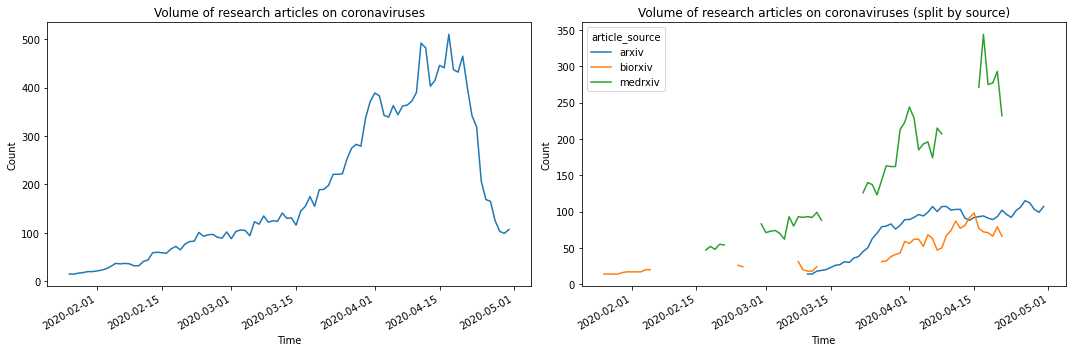

In [177]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
m = covid_df[(covid_df.year == 2020) & (covid_df.month_year < datem)].groupby("created")['id'].count().rolling(7).sum()
m.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_title('Volume of research articles on coronaviruses')
ax1.set_ylabel('Count')


# ax2
m = covid_df[(covid_df.year == 2020) & (covid_df.month_year < datem)].groupby(["article_source", "created"])['id'].count().unstack('article_source').rolling(7).sum()
m.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_title('Volume of research articles on coronaviruses (split by source)')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()

## Preprocess abstracts

In [11]:
# Drop papers without an abstract
covid_papers = covid_df.dropna(subset=['abstract'])

# Tokenise paper abstracts
abstracts = [clean_and_tokenize(d, remove_stops=True) for d in covid_papers.abstract]

In [12]:
# Create trigrams
phrases = Phrases(abstracts, min_count=5, threshold=10)
bigram = Phraser(phrases)
trigram = Phrases(bigram[abstracts], min_count=5, threshold=1)
abstracts_with_ngrams = list(trigram[abstracts])

2020-05-07 13:27:09,219 - gensim.models.phrases - INFO - collecting all words and their counts
2020-05-07 13:27:09,219 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 13:27:09,643 - gensim.models.phrases - INFO - collected 219221 word types from a corpus of 311055 words (unigram + bigrams) and 2624 sentences
2020-05-07 13:27:09,643 - gensim.models.phrases - INFO - using 219221 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10, max_vocab_size=40000000>
2020-05-07 13:27:09,644 - gensim.models.phrases - INFO - source_vocab length 219221
2020-05-07 13:27:11,241 - gensim.models.phrases - INFO - Phraser built with 2353 phrasegrams
2020-05-07 13:27:11,242 - gensim.models.phrases - INFO - collecting all words and their counts
2020-05-07 13:27:11,243 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-07 13:27:12,174 - gensim.models.phrases - INFO - collected 233039 word types 

## Find ML papers

In [13]:
w2v = gensim.models.Word2Vec(abstracts_with_ngrams, size=300, window=10, min_count=5, seed=42, iter=10)
# Found the following keywords by querying the word2vec model with ML tokens
# w2v.wv.most_similar(['machine_learning'], topn=30)
ml_keywords = [
    'optimization_algorithm', 'convolutional_neural', 'automatic_detection', 'transfer_learning', 
    'semi_supervised', 'dnn', 'pre_trained', 'artificial_intelligence', 'natural_language', 
    'deep_learning', 'machine_learning', 'training_dataset', 'covid_net', 'classification', 
    'cnn', 'learning_based', 'deep_neural', 'neural_network', 'feature_extraction', 'deep_convolutional',
]

2020-05-07 13:27:13,057 - gensim.models.word2vec - INFO - collecting all words and their counts
2020-05-07 13:27:13,058 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-07 13:27:13,106 - gensim.models.word2vec - INFO - collected 21373 word types from a corpus of 267727 raw words and 2624 sentences
2020-05-07 13:27:13,107 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2020-05-07 13:27:13,144 - gensim.models.word2vec - INFO - effective_min_count=5 retains 8801 unique words (41% of original 21373, drops 12572)
2020-05-07 13:27:13,145 - gensim.models.word2vec - INFO - effective_min_count=5 leaves 246729 word corpus (92% of original 267727, drops 20998)
2020-05-07 13:27:13,166 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 21373 items
2020-05-07 13:27:13,167 - gensim.models.word2vec - INFO - sample=0.001 downsamples 15 most-common words
2020-05-07 13:27:13,167 - gensim.models.word2vec - INFO - 

In [14]:
is_ai = []
for i, tokens in enumerate(abstracts_with_ngrams):
    if any(k in tokens for k in ml_keywords):
        is_ai.append(1)
    else:
        is_ai.append(0)
        
covid_papers['is_AI'] = is_ai

<ipython-input-14-4b2b25dd780b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_papers['is_AI'] = is_ai


In [15]:
print(f'Total AI papers published in 2020: {covid_papers[(covid_papers.year==2020) & (covid_papers.is_AI==1)].shape[0] }')

Total AI papers published in 2020: 215


I found this many AI papers in the covid-19 dataset:
- arxiv: 132
- medrxiv: 61
- biorxiv: 24

This is more or less aligned with a similar exploration I did in the CORD19 dataset where I found this number of AI papers by following a previously used [keyword matching approach](https://arxiv.org/abs/2003.11336):
- medrxiv: 60
- biorxiv: 28

(Note: arXiv is not part of CORD19)

In [16]:
covid_papers[covid_papers['is_AI']==1].article_source.value_counts()

arxiv      132
medrxiv     61
biorxiv     24
Name: article_source, dtype: int64

#### Volume of AI publications in 2020

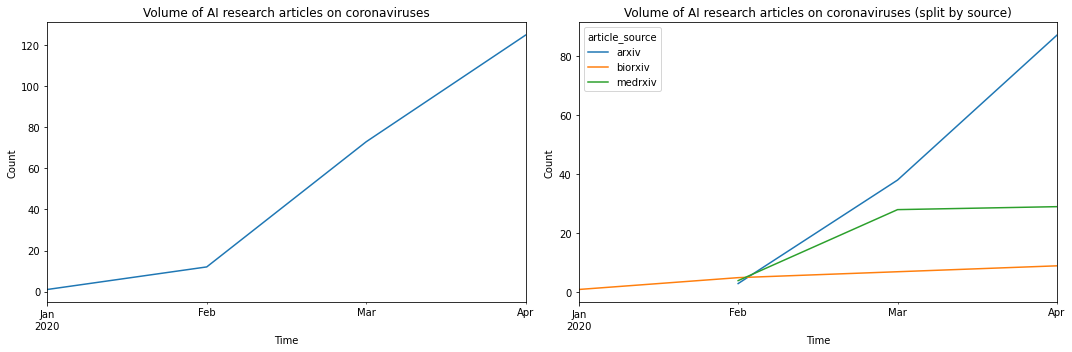

In [17]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
m = covid_papers[(covid_papers.year == 2020) & (covid_papers.month_year < datem) & (covid_papers.is_AI==1)].groupby("month_year")['id'].count()
m.plot(ax=ax1)
ax1.set_xlabel('Time')
ax1.set_title('Volume of AI research articles on coronaviruses')
ax1.set_ylabel('Count')


# ax2
m = covid_papers[(covid_papers.year == 2020) & (covid_papers.month_year < datem) & (covid_papers.is_AI==1)].groupby(["article_source", "month_year"])['id'].count().unstack('article_source')
m.plot(ax=ax2)
ax2.set_xlabel('Time')
ax2.set_title('Volume of AI research articles on coronaviruses (split by source)')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()

## Identifying thematic topics

Post model fitting note: LDA's topic coherence (`c_v`) is .4072 while HDP's is .57.

### LDA

In [18]:
# Create dictionary
dictionary = gensim.corpora.Dictionary(abstracts_with_ngrams)

# Create BoW
bow = [dictionary.doc2bow(document) for document in abstracts_with_ngrams]

2020-05-07 13:27:25,222 - gensim.corpora.dictionary - INFO - adding document #0 to Dictionary(0 unique tokens: [])
2020-05-07 13:27:25,526 - gensim.corpora.dictionary - INFO - built Dictionary(21373 unique tokens: ['alertness', 'allows', 'analyses', 'analysis', 'analysis_provides']...) from 2624 documents (total 267727 corpus positions)


In [ ]:
%%time
# Train multicore LDA
lda_model = gensim.models.LdaMulticore(corpus=bow, 
                                       id2word=dictionary, 
                                       num_topics=10,
                                       passes=20,
                                       alpha='asymmetric', 
                                       eta='auto',
                                       iterations=150
                                      )

In [19]:
# lda_model = gensim.models.LdaMulticore.load('../../models/lda_10_20_150.lda')

2020-05-07 13:27:29,846 - gensim.utils - INFO - loading LdaMulticore object from ../../models/lda_10_20_150.lda
2020-05-07 13:27:29,850 - gensim.utils - INFO - loading expElogbeta from ../../models/lda_10_20_150.lda.expElogbeta.npy with mmap=None
2020-05-07 13:27:29,852 - gensim.utils - INFO - setting ignored attribute state to None
2020-05-07 13:27:29,853 - gensim.utils - INFO - setting ignored attribute dispatcher to None
2020-05-07 13:27:29,853 - gensim.utils - INFO - setting ignored attribute id2word to None
2020-05-07 13:27:29,853 - gensim.utils - INFO - loaded ../../models/lda_10_20_150.lda
2020-05-07 13:27:29,854 - gensim.utils - INFO - loading LdaState object from ../../models/lda_10_20_150.lda.state
2020-05-07 13:27:29,861 - gensim.utils - INFO - loaded ../../models/lda_10_20_150.lda.state


In [20]:
for topic_num, words in lda_model.show_topics(-1, formatted=False):
    print(f'Topic: {topic_num}')
    print([word[0] for word in words])

Topic: 0
['infection', 'patients', 'reported', 'cases', 'disease', 'results', 'infections', 'data', 'time', 'number']
Topic: 1
['virus', 'human', 'cells', 'coronavirus', 'viral', 'protein', 'infection', 'sars_cov', 'potential', 'found']
Topic: 2
['cases', 'china', 'outbreak', 'data', 'model', 'time', 'number', 'based', 'countries', 'disease']
Topic: 3
['patients', 'treatment', 'cases', 'group', 'disease', 'admission', 'results', 'compared', 'infection', 'age']
Topic: 4
['cases', 'china', 'wuhan', 'outbreak', 'epidemic', 'transmission', 'estimated', 'data', 'cfr', 'results']
Topic: 5
['model', 'data', 'using', 'cases', 'models', 'based', 'also', 'results', 'method', 'well']
Topic: 6
['pandemic', 'samples', 'trials', 'using', 'use', 'methods', 'control', 'research', 'patients', 'results']
Topic: 7
['model', 'epidemic', 'data', 'social_distancing', 'pandemic', 'measures', 'countries', 'population', 'time', 'lockdown']
Topic: 8
['symptoms', 'patients', 'cases', 'data', 'influenza', 'infect

In [21]:
# lda_model.save('../../models/lda_10_20_150.lda')

In [116]:
# cm = gensim.models.CoherenceModel(model=lda_model, texts=abstracts_with_ngrams, corpus=bow, coherence='c_v')
# coherence = cm.get_coherence()
# print(coherence)

In [21]:
# Create an empty dataframe
covid_topics = pd.DataFrame(0, index=covid_papers.index, columns=[tup[0] for tup in lda_model.show_topics(-1)])

# Populate the empty dataframe with topics and their proportions
for i, bag_of_words in enumerate(bow):
    doc_topics = lda_model.get_document_topics(bag_of_words)
    for doc_topic in doc_topics:
        covid_topics.iloc[i, doc_topic[0]] = doc_topic[1]
        
covid_papers = pd.concat([covid_papers, covid_topics], axis=1)

#### Most used topics in AI papers

Topic 9 is the most used one in the AI subset of the COVID-19 papers. That's reasonable. Some of the high-probable words in Topic 9 are "deep learning" and "dataset".

I also did a very basic attempt to check if there are any correlated topics - doesn't look like.

In [22]:
# Sum of topic proportions for the AI subset
covid_papers[covid_papers.is_AI==1].iloc[:, 10:].sum()

0    21.086159
1    28.625230
2    17.616257
3    13.077540
4     2.923149
5    11.157137
6     5.624152
7    29.463474
8     4.048002
9    81.598248
dtype: float64

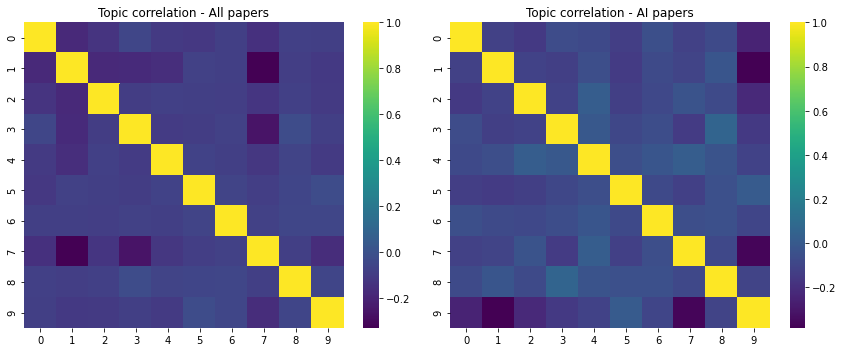

In [23]:
f, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

# All papers
sns.heatmap(covid_papers.iloc[:, 10:].corr(), cmap='viridis', ax=ax1)
ax1.set_title('Topic correlation - All papers')

# AI subset
sns.heatmap(covid_papers[covid_papers.is_AI==1].iloc[:, 10:].corr(), cmap='viridis', ax=ax2)
ax2.set_title('Topic correlation - AI papers')

f.tight_layout()
plt.show()

To measure the activity in thematic topics, I will do the following:
- Label a topic by its top 4 words (ie the ones with the highest probability of occurring in that topic)
- Binarize them (1=topic proportion larger than .1, 0=topic proportion smaller than .1)

In [24]:
# Topic labelling
topic_label_mapping = {}
for topic_num, words in lda_model.show_topics(-1, formatted=False):
    topic_label_mapping[topic_num] = '_'.join([word[0] for word in words][:4])

In [25]:
topic_label_mapping

{0: 'infection_patients_reported_cases',
 1: 'virus_human_cells_coronavirus',
 2: 'cases_china_outbreak_data',
 3: 'patients_treatment_cases_group',
 4: 'cases_china_wuhan_outbreak',
 5: 'model_data_using_cases',
 6: 'pandemic_samples_trials_using',
 7: 'model_epidemic_data_social_distancing',
 8: 'symptoms_patients_cases_data',
 9: 'using_detection_images_diagnosis'}

In [49]:
# Binarise topics
binary_topics = covid_papers.iloc[:, 10:].where(covid_papers.iloc[:, 10:] < 0.1).fillna(1)
binary_topics = binary_topics.where(binary_topics > 0.1).fillna(0)

# Concant binary topics with original papers
covid_papers_binary_topics = pd.concat([covid_papers.iloc[:, :10], binary_topics], axis=1)

# Rename topics using the mapping
covid_papers_binary_topics.rename(index=str, inplace=True, columns=topic_label_mapping)

# Keep only AI publications
ai_papers = covid_papers_binary_topics[covid_papers_binary_topics.is_AI==1]

In [130]:
# Sum of topic proportions for the AI subset
ai_papers.iloc[:, 10:].sum()

infection_patients_reported_cases         46.0
virus_human_cells_coronavirus             59.0
cases_china_outbreak_data                 43.0
patients_treatment_cases_group            34.0
cases_china_wuhan_outbreak                10.0
model_data_using_cases                    30.0
pandemic_samples_trials_using             12.0
model_epidemic_data_social_distancing     68.0
symptoms_patients_cases_data              10.0
using_detection_images_diagnosis         149.0
dtype: float64

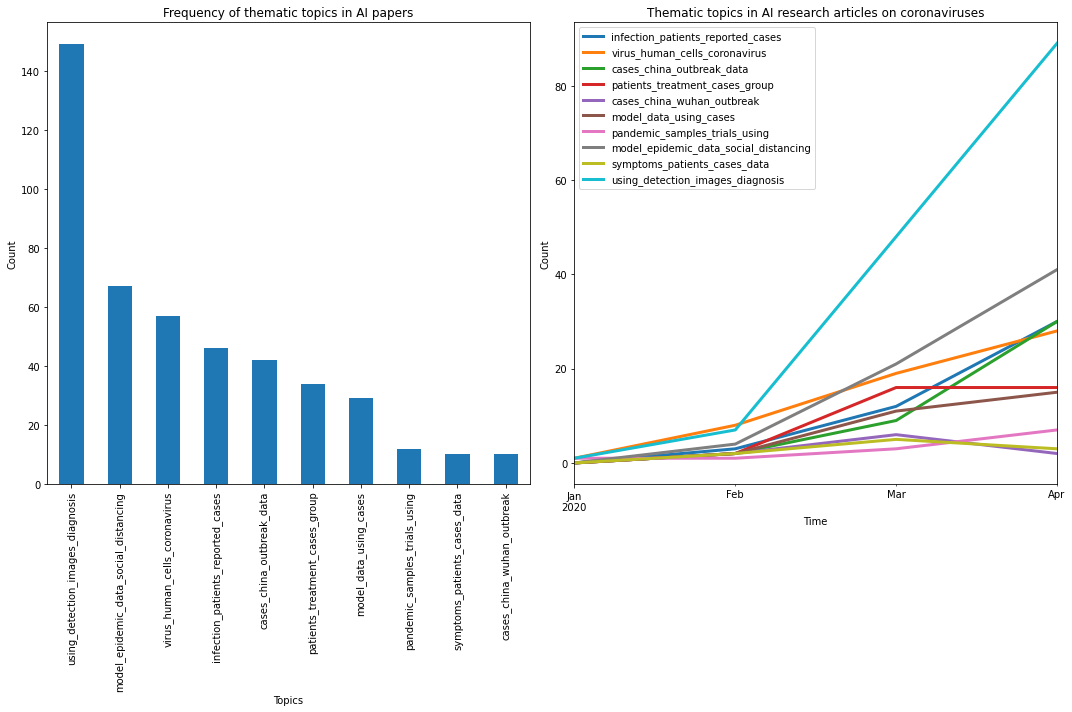

In [51]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))

# Today's year and month
today = datetime.today()
datem = datetime(today.year, today.month, 1)
datem = pd.to_datetime(datem).to_period('M')

# ax1
ai_papers[ai_papers.year==2020].iloc[:, 10:].sum().sort_values(ascending=False).plot(kind='bar', ax=ax1)
ax1.set_xlabel('Topics')
ax1.set_title('Frequency of thematic topics in AI papers')
ax1.set_ylabel('Count')


# ax2
m = ai_papers[(ai_papers.year == 2020) & (ai_papers.month_year < datem)].groupby(["month_year"])[list(topic_label_mapping.values())].sum()
m.plot(ax=ax2, linewidth=3)
ax2.set_xlabel('Time')
ax2.set_title('Thematic topics in AI research articles on coronaviruses')
ax2.set_ylabel('Count')

f.tight_layout()
plt.show()

## Stastical difference between the proportions of AI/non-AI papers in thematic topics

In [168]:
for topic in topic_label_mapping.values():
    stat, pval = two_proportions_test(pd.crosstab(covid_papers_binary_topics['is_AI'],
                                                  covid_papers_binary_topics[topic]), 
                                     )
    print(f'{topic}: zstat: {stat}, pval:{pval} \n')

infection_patients_reported_cases: zstat: 1.1823536643250767, pval:0.8814672997715447 

virus_human_cells_coronavirus: zstat: 1.469201124147172, pval:0.9291108772537708 

cases_china_outbreak_data: zstat: 0.1899355811052585, pval:0.5753201948727338 

patients_treatment_cases_group: zstat: 2.5238367033343025, pval:0.9941959081645783 

cases_china_wuhan_outbreak: zstat: 4.928017357256869, pval:0.9999995846588039 

model_data_using_cases: zstat: -2.0391964975492116, pval:0.020715210167007184 

pandemic_samples_trials_using: zstat: 1.42036440730387, pval:0.9222491903826197 

model_epidemic_data_social_distancing: zstat: 3.608443964255929, pval:0.9998459804855075 

symptoms_patients_cases_data: zstat: 1.3896026955854657, pval:0.917675221616782 

using_detection_images_diagnosis: zstat: -22.70025306833912, pval:2.227121682663697e-114 



In [196]:
d = defaultdict(list)
for topic in topic_label_mapping.values():
    # Crosstab by is_AI and topic
    frame = pd.crosstab(covid_papers_binary_topics['is_AI'], covid_papers_binary_topics[topic])
    # Proportion of AI papers with that topic
    prop = frame.loc[1, 1] / frame.loc[1].sum()
    stat, pval = two_proportions_test(frame)
    d['topic'].append(topic)
    d['proportion'].append(prop)
    if pval < .05:
        d['significant'].append(1)
    else:
        d['significant'].append(-1)

In [209]:
ai_proportions = pd.DataFrame.from_dict(d, orient='index').T.sort_values('proportion', ascending=True)

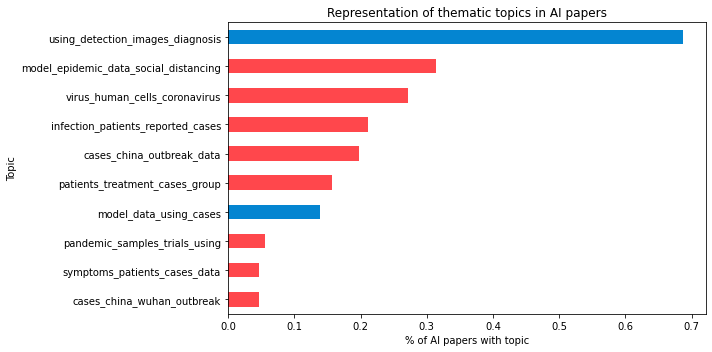

In [222]:
f, ax = plt.subplots(ncols=1, figsize=(10,5))
ai_proportions.set_index('topic').proportion.plot(kind='barh', ax=ax, color=['#0485d1' if s==1 else '#ff474c' for s in ai_proportions.significant])
ax.set_title('Representation of thematic topics in AI papers')
ax.set_xlabel('% of AI papers with topic')
ax.set_ylabel('Topic')

f.tight_layout()
plt.show()